In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install openpyxl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/sinyal-gsr-1/Sinyal Sensor Polar HR HRV ECG.xlsx'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_30/1779580676.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['label'].replace({'bugar': 0, 'lelah': 1}).astype(int)


Random Forest Model Accuracy: 87.76%

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       265
           1       0.86      0.95      0.90       413

    accuracy                           0.88       678
   macro avg       0.89      0.86      0.87       678
weighted avg       0.88      0.88      0.88       678

Confusion Matrix:
[[202  63]
 [ 20 393]]


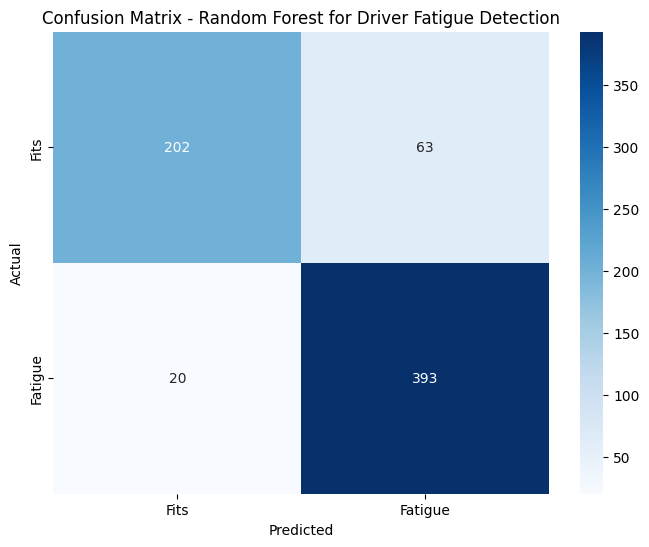

Area Under the ROC Curve (AUC): 0.93


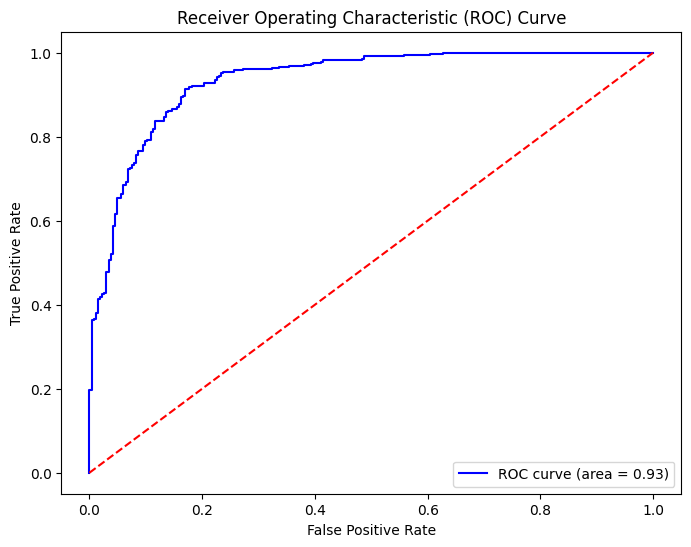


Predicted condition: fits (Confidence: 0.87)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [5]:
# Random Forest 87,76%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Load dataset
data = pd.read_excel('/kaggle/input/gsr-data-bersih/data_bersih_gsr.xlsx')

# Preprocessing: Separate features and labels
X = data[['HR [bpm]', 'HRV [ms]', 'RR-interval [ms]', 'ecg [uV]']].copy()

# Add statistical features from ECG with a smaller window
window_size = 5
X['ecg_mean'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).mean()
X['ecg_std'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).std()
X['ecg_min'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).min()
X['ecg_max'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).max()

# Add more advanced features
X['HR_HRV_ratio'] = X['HR [bpm]'] / X['HRV [ms]'].replace(0, np.nan)
X['HR_RR_ratio'] = X['HR [bpm]'] / X['RR-interval [ms]'].replace(0, np.nan)
X['ecg_range'] = X['ecg_max'] - X['ecg_min']
X['ecg_kurtosis'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).kurt()
X['ecg_skew'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).skew()

# Label (fits or fatigue) with mapping
y = data['label'].replace({'bugar': 0, 'lelah': 1}).astype(int)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Normalize the data
scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate Random Forest model
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Model Accuracy: {rf_accuracy * 100:.2f}%")

# Print classification report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Menampilkan confusion matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fits', 'Fatigue'], yticklabels=['Fits', 'Fatigue'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest for Driver Fatigue Detection')
plt.show()

# Menghitung probabilitas prediksi untuk ROC curve
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Menghitung ROC curve dan AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f'Area Under the ROC Curve (AUC): {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Function for real-time prediction
def predict_real_time(hr_bpm, hrv_ms, rr_interval_ms, ecg_values):
    # Calculate ECG features
    ecg_mean = np.mean(ecg_values)
    ecg_std = np.std(ecg_values)
    ecg_min = np.min(ecg_values)
    ecg_max = np.max(ecg_values)
    ecg_range = ecg_max - ecg_min
    ecg_kurtosis = pd.Series(ecg_values).kurtosis()
    ecg_skew = pd.Series(ecg_values).skew()
    
    # Create input data
    input_data = np.array([[
        hr_bpm, hrv_ms, rr_interval_ms, ecg_values[-1],
        ecg_mean, ecg_std, ecg_min, ecg_max,
        hr_bpm / hrv_ms if hrv_ms != 0 else np.nan,
        hr_bpm / rr_interval_ms if rr_interval_ms != 0 else np.nan,
        ecg_range, ecg_kurtosis, ecg_skew
    ]])
    
    # Impute missing values
    input_imputed = imputer.transform(input_data)
    
    # Scale input data
    input_scaled = scaler.transform(input_imputed)
    
    # Make predictions using Random Forest
    rf_pred = rf_model.predict_proba(input_scaled)
    label_idx = np.argmax(rf_pred, axis=1)
    label = ['fits', 'fatigue'][label_idx[0]]
    confidence = rf_pred[0, label_idx[0]]
    
    return label, confidence

# Example usage of real-time prediction
ecg_values_example = [2737, 2188, 2354, 2312, 2060]
result, confidence = predict_real_time(114, 34, 1047, ecg_values_example)
print(f'\nPredicted condition: {result} (Confidence: {confidence:.2f})')

/tmp/ipykernel_30/1144536663.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['label'].replace({'bugar': 0, 'lelah': 1}).astype(int)


Epoch 1/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6449 - loss: 0.8375 - val_accuracy: 0.7643 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 2/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7070 - loss: 0.6609 - val_accuracy: 0.7587 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 3/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7213 - loss: 0.5962 - val_accuracy: 0.7845 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 4/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7213 - loss: 0.5568 - val_accuracy: 0.7680 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 5/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7558 - loss: 0.5099 - val_accuracy: 0.7993 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 6/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7539 - loss: 0.5041 - val_accuracy: 0.8048 - val_loss: 0.4489 - learning_rate: 0.0010
Epoch 7/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7166 - loss: 0.5390 - 

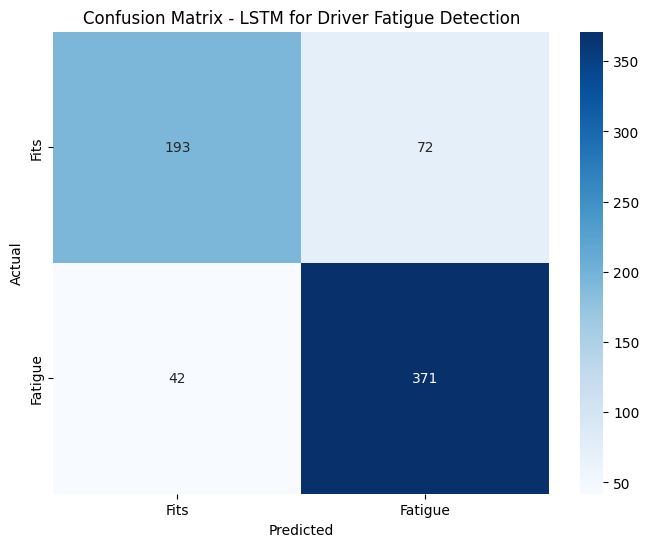

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Area Under the ROC Curve (AUC) for LSTM: 0.89


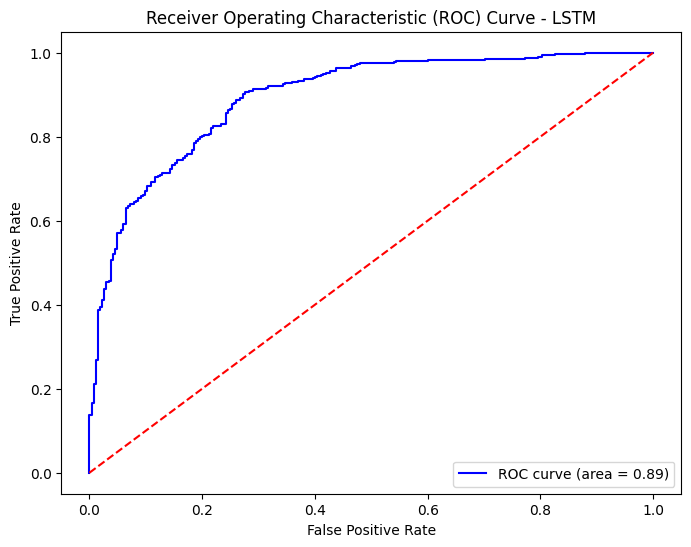

Random Forest Model Accuracy: 87.76%

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       265
           1       0.86      0.95      0.90       413

    accuracy                           0.88       678
   macro avg       0.89      0.86      0.87       678
weighted avg       0.88      0.88      0.88       678



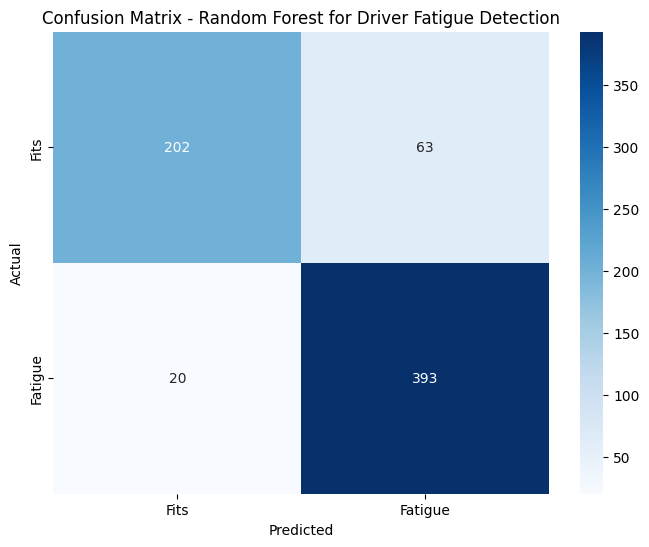

Area Under the ROC Curve (AUC): 0.93


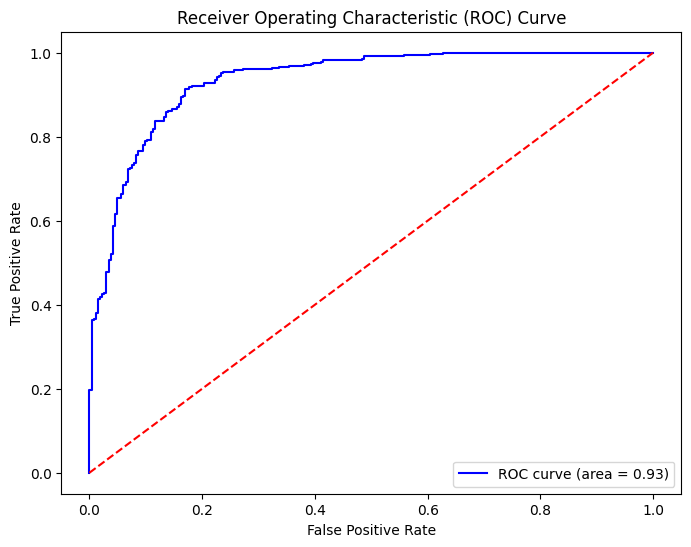

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Predicted condition: fits (Confidence: 0.91)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [4]:
# Random Forest 87,76% + LSTM 83,19% (Not full run approximately 86,19% if full run)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_excel('/kaggle/input/gsr-data-bersih/data_bersih_gsr.xlsx')

# Preprocessing: Separate features and labels
X = data[['HR [bpm]', 'HRV [ms]', 'RR-interval [ms]', 'ecg [uV]']].copy()

# Add statistical features from ECG with a smaller window
window_size = 5
X['ecg_mean'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).mean()
X['ecg_std'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).std()
X['ecg_min'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).min()
X['ecg_max'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).max()

# Additional advanced features
X['HR_HRV_ratio'] = X['HR [bpm]'] / X['HRV [ms]'].replace(0, np.nan)
X['HR_RR_ratio'] = X['HR [bpm]'] / X['RR-interval [ms]'].replace(0, np.nan)
X['ecg_range'] = X['ecg_max'] - X['ecg_min']

# Label (fits or fatigue) with mapping
y = data['label'].replace({'bugar': 0, 'lelah': 1}).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Impute and scale data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Reshape data for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# One-hot encoding for labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Build LSTM model
def create_lstm_model(input_shape, units=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(units, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units // 2, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(2, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the LSTM model
lstm_model = create_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = lstm_model.fit(
    X_train_lstm, y_train_encoded,
    epochs=200, batch_size=32, validation_split=0.2,
    callbacks=[early_stopping, reduce_lr], verbose=1
)

# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_encoded)
print(f"LSTM Model Accuracy: {lstm_accuracy * 100:.2f}%")

# Evaluate LSTM model
lstm_predictions = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
lstm_conf_matrix = confusion_matrix(y_test, lstm_predictions)
print("\nLSTM Classification Report:")
print(classification_report(y_test, lstm_predictions))

# Menampilkan confusion matrix untuk LSTM
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fits', 'Fatigue'], yticklabels=['Fits', 'Fatigue'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM for Driver Fatigue Detection')
plt.show()

# Menghitung probabilitas prediksi untuk ROC curve
lstm_probabilities = lstm_model.predict(X_test_lstm)[:, 1]

# Menghitung ROC curve dan AUC untuk LSTM
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, lstm_probabilities)
roc_auc_lstm = roc_auc_score(y_test, lstm_probabilities)
print(f'Area Under the ROC Curve (AUC) for LSTM: {roc_auc_lstm:.2f}')

# Plot ROC curve untuk LSTM
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LSTM')
plt.legend(loc='lower right')
plt.show()

# Train a Random Forest model for comparison
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate Random Forest model
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Model Accuracy: {rf_accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report for Random Forest
conf_matrix = confusion_matrix(y_test, rf_predictions)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fits', 'Fatigue'], yticklabels=['Fits', 'Fatigue'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest for Driver Fatigue Detection')
plt.show()

# Menghitung probabilitas prediksi untuk ROC curve
rf_probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]

# Menghitung ROC curve dan AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)
roc_auc = roc_auc_score(y_test, rf_probabilities)
print(f'Area Under the ROC Curve (AUC): {roc_auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Function for real-time prediction
def predict_real_time(hr_bpm, hrv_ms, rr_interval_ms, ecg_values):
    # Calculate ECG features
    ecg_mean = np.mean(ecg_values)
    ecg_std = np.std(ecg_values)
    ecg_min = np.min(ecg_values)
    ecg_max = np.max(ecg_values)
    ecg_range = ecg_max - ecg_min
    ecg_kurtosis = pd.Series(ecg_values).kurtosis()
    ecg_skew = pd.Series(ecg_values).skew()
    
    # Create input data
    input_data = np.array([[hr_bpm, hrv_ms, rr_interval_ms, ecg_values[-1],
                             ecg_mean, ecg_std, ecg_min, ecg_max,
                             hr_bpm / hrv_ms if hrv_ms != 0 else np.nan,
                             hr_bpm / rr_interval_ms if rr_interval_ms != 0 else np.nan,
                             ecg_range, ecg_kurtosis, ecg_skew]])
    
    # Impute missing values
    input_imputed = imputer.transform(input_data)
    
    # Scale input data
    input_scaled = scaler.transform(input_imputed)
    
    # Make predictions using both models
    lstm_input = input_scaled.reshape((1, 1, input_scaled.shape[1]))
    lstm_pred = lstm_model.predict(lstm_input)
    rf_pred = rf_model.predict_proba(input_scaled)
    
    # Ensemble prediction (average of LSTM and RF probabilities)
    ensemble_pred = (lstm_pred + rf_pred) / 2
    label_idx = np.argmax(ensemble_pred, axis=1)
    label = ['fits', 'fatigue'][label_idx[0]]
    confidence = ensemble_pred[0, label_idx[0]]
    
    return label, confidence

# Example usage of real-time prediction
ecg_values_example = [2737, 2188, 2354, 2312, 2060]
result, confidence = predict_real_time(114, 34, 1047, ecg_values_example)
print(f'\nPredicted condition: {result} (Confidence: {confidence:.2f})')